In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import timm  # For Vision Transformer
import numpy as np

C:\Users\abdul\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


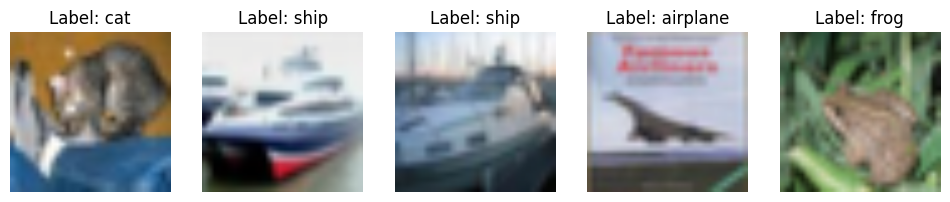

In [2]:
import matplotlib.pyplot as plt

# ImageNet normalization values
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

# Normal transform
transform_normal = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# CIFAR-10 (original)
train_dataset_normal = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_normal)
test_dataset_normal  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_normal)

# For visualization (un-normalize to show properly)
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    std=[1/s for s in imagenet_std]
)

# Show 5 example images
fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    img, label = test_dataset_normal[i]
    img = unnormalize(img).permute(1, 2, 0).numpy().clip(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {test_dataset_normal.classes[label]}")
    axes[i].axis("off")
plt.show()


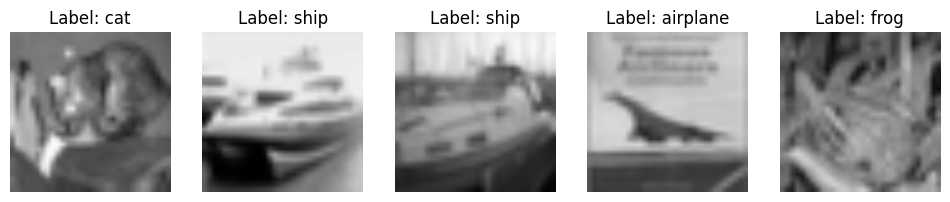

In [3]:
import matplotlib.pyplot as plt

# Grayscale transform pipeline
grayscale_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # keep 3 channels for CNN/ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

cifar10_grayscale = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=grayscale_transform)

# Show 5 grayscale samples
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = cifar10_grayscale[i]
    img = img.permute(1, 2, 0).numpy()  # to HWC
    img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])).clip(0,1)  # unnormalize for display
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {cifar10_grayscale.classes[label]}")
    axes[i].axis("off")
plt.show()


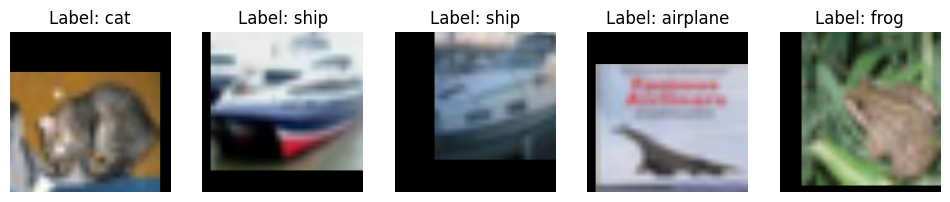

In [4]:
# Translate transform (shift by ±4 pixels)
torch.manual_seed(42)
rand_number = 0.1 + 0.2 * torch.rand(1).item()

translate_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, translate=(rand_number, rand_number)),  # 10% shift
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

cifar10_translated = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=translate_transform)

# Show 5 translated samples
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = cifar10_translated[i]
    img = img.permute(1, 2, 0).numpy()
    img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])).clip(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {cifar10_translated.classes[label]}")
    axes[i].axis("off")
plt.show()


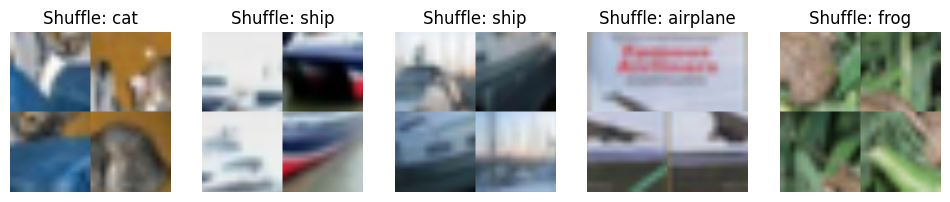

In [5]:
# Custom patch shuffle
def shuffle_patches(img, num_patches=4):
    w, h = img.size
    patch_w, patch_h = w // num_patches, h // num_patches

    patches = []
    for i in range(num_patches):
        for j in range(num_patches):
            box = (j*patch_w, i*patch_h, (j+1)*patch_w, (i+1)*patch_h)
            patches.append(img.crop(box))

    np.random.shuffle(patches)

    new_img = Image.new("RGB", (w, h))
    idx = 0
    for i in range(num_patches):
        for j in range(num_patches):
            new_img.paste(patches[idx], (j*patch_w, i*patch_h))
            idx += 1
    return new_img

from PIL import Image

transform_patchshuffle = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: shuffle_patches(img, num_patches=2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset_patch = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_patchshuffle)
test_dataset_patch  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_patchshuffle)

# Show 5 shuffled images
fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    img, label = test_dataset_patch[i]
    img = unnormalize(img).permute(1, 2, 0).numpy().clip(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"Shuffle: {test_dataset_patch.classes[label]}")
    axes[i].axis("off")
plt.show()


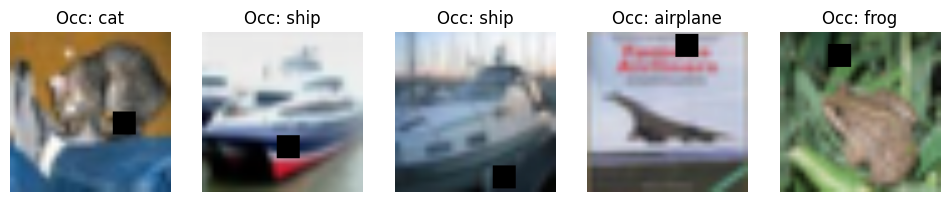

In [6]:
# Custom occlusion (mask a random square)
torch.manual_seed(42)
def occlude_image(img, occ_size=24):
    w, h = img.size
    x0 = np.random.randint(0, w - occ_size)
    y0 = np.random.randint(0, h - occ_size)
    img = img.copy()
    mask = Image.new("RGB", (occ_size, occ_size), (0,0,0))
    img.paste(mask, (x0, y0))
    return img

transform_occluded = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: occlude_image(img, occ_size=32)), #default 24
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset_occ = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_occluded)
test_dataset_occ  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_occluded)

# Show 5 occluded images
fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    img, label = test_dataset_occ[i]
    img = unnormalize(img).permute(1, 2, 0).numpy().clip(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"Occ: {test_dataset_occ.classes[label]}")
    axes[i].axis("off")
plt.show()


In [7]:
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image

# Normalization
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

# ----- Custom transforms -----
def translate_image(img, max_shift=5):
    torch.manual_seed(42)
    dx, dy = np.random.randint(-max_shift, max_shift+1, size=2)
    return transforms.functional.affine(img, angle=0, translate=(dx, dy), scale=1, shear=0)

def shuffle_patches(img, num_patches=4):
    torch.manual_seed(42)
    w, h = img.size
    patch_w, patch_h = w // num_patches, h // num_patches
    patches = []
    for i in range(num_patches):
        for j in range(num_patches):
            box = (j*patch_w, i*patch_h, (j+1)*patch_w, (i+1)*patch_h)
            patches.append(img.crop(box))
    np.random.shuffle(patches)
    new_img = Image.new("RGB", (w, h))
    idx = 0
    for i in range(num_patches):
        for j in range(num_patches):
            new_img.paste(patches[idx], (j*patch_w, i*patch_h))
            idx += 1
    return new_img

def occlude_image(img, occ_size=24):
    torch.manual_seed(42)
    w, h = img.size
    x0 = np.random.randint(0, w - occ_size)
    y0 = np.random.randint(0, h - occ_size)
    img = img.copy()
    mask = Image.new("RGB", (occ_size, occ_size), (0,0,0))
    img.paste(mask, (x0, y0))
    return img

# ----- Datasets -----
def get_cifar10_datasets(root="./data"):
    cnn_transform_normal = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    cnn_transform_gray = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    cnn_transform_translate = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.Lambda(lambda img: translate_image(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    cnn_transform_patchshuffle = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.Lambda(lambda img: shuffle_patches(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    cnn_transform_occluded = transforms.Compose([
        transforms.Resize((96,96)),
        transforms.Lambda(lambda img: occlude_image(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    vit_transform_normal = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    vit_transform_gray = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    vit_transform_translate = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: translate_image(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    vit_transform_patchshuffle = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: shuffle_patches(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    vit_transform_occluded = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: occlude_image(img)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    # Load CIFAR-10 once, apply different transforms
    cnn_train_normal = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=cnn_transform_normal)
    cnn_test_normal  = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=cnn_transform_normal)

    cnn_train_gray = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=cnn_transform_gray)
    cnn_test_gray  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=cnn_transform_gray)

    cnn_train_trans = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=cnn_transform_translate)
    cnn_test_trans  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=cnn_transform_translate)

    cnn_train_patch = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=cnn_transform_patchshuffle)
    cnn_test_patch  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=cnn_transform_patchshuffle)

    cnn_train_occ = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=cnn_transform_occluded)
    cnn_test_occ  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=cnn_transform_occluded)

    vit_train_normal = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=vit_transform_normal)
    vit_test_normal  = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=vit_transform_normal)

    vit_train_gray = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=vit_transform_gray)
    vit_test_gray  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=vit_transform_gray)

    vit_train_trans = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=vit_transform_translate)
    vit_test_trans  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=vit_transform_translate)

    vit_train_patch = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=vit_transform_patchshuffle)
    vit_test_patch  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=vit_transform_patchshuffle)

    vit_train_occ = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=vit_transform_occluded)
    vit_test_occ  = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=vit_transform_occluded)

    return {
        "cnn_normal": (cnn_train_normal, cnn_test_normal),
        "cnn_gray": (cnn_train_gray, cnn_test_gray),
        "cnn_translate": (cnn_train_trans, cnn_test_trans),
        "cnn_patch": (cnn_train_patch, cnn_test_patch),
        "cnn_occluded": (cnn_train_occ, cnn_test_occ),
        "vit_normal": (vit_train_normal, vit_test_normal),
        "vit_gray": (vit_train_gray, vit_test_gray),
        "vit_translate": (vit_train_trans, vit_test_trans),
        "vit_patch": (vit_train_patch, vit_test_patch),
        "vit_occluded": (vit_train_occ, vit_test_occ),
    }
